In [ ]:
!pip install requirements.txt

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.curdir)))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.data import *
import warnings
warnings.filterwarnings("ignore")

<font size="6">Loading data..</font>

In [2]:
data = load_data(os.path.join(dataset_path, 'train.csv'))
print(data.head(20))

        ID        PeptideSequence Modifications  RetentionTime
0    66442     EELNAISGPNEFAEFYDR           NaN      76.808103
1     9346              VPAQSESVR           NaN     -35.365414
2    87137             SEPEDPVTER           NaN     -12.258285
3    31419             SIRPGLSPYR           NaN      -0.953151
4    93265          NLINEMLTINPAK           NaN      88.572770
5    74513              IQPDYPAER           NaN      -4.333334
6   103807              VDREQLVQK      1|Acetyl       4.033374
7    46965              LAQFVEHWK           NaN      24.551452
8    71173              GLFATQLIR           NaN      60.780689
9    80030        VLTANSNPSSPSAAK           NaN     -18.356355
10    8895          VISESPPDQWEAR           NaN      26.270934
11   47381             NAAALSEALR           NaN      17.070998
12   57384            YRPEEVDIDAK           NaN       1.006815
13  108318           IILDLISESPIK           NaN      90.870488
14    7553  GTLSAELTAAHFGGGGGLLHK           NaN      48

<font size="6">Data statistics</font>

In [3]:
print(f"Data length: {len(data)}")
print(f"Data columns: {data.columns}")
print(f"types of columns values: \n{data.dtypes}")
print(f"amount of missing values: \n{data.isnull().sum()}")
print(f"amount of unique values: \n{data.nunique()}")
print(f"General statistics: \n{data.describe()}")
print(f"Amount of duplicated rows: \n{data.duplicated().sum()}")

Data length: 10000
Data columns: Index(['ID', 'PeptideSequence', 'Modifications', 'RetentionTime'], dtype='object')
types of columns values: 
ID                   int64
PeptideSequence     object
Modifications       object
RetentionTime      float64
dtype: object
amount of missing values: 
ID                    0
PeptideSequence       0
Modifications      9175
RetentionTime         0
dtype: int64
amount of unique values: 
ID                 10000
PeptideSequence     9936
Modifications         48
RetentionTime       9996
dtype: int64
General statistics: 
                  ID  RetentionTime
count   10000.000000   10000.000000
mean    56241.349900      43.962328
std     32857.783193      46.414624
min         2.000000    -131.607569
25%     27632.750000      10.709574
50%     56120.000000      44.089721
75%     84700.000000      76.710009
max    113159.000000     147.746952
Amount of duplicated rows: 
0


<font size="6">Data visualization</font>

In [4]:
text_col = 'PeptideSequence'
data[f"{text_col}_length"] = data[text_col].str.len()
numerical_cols = [f"{text_col}_length"]

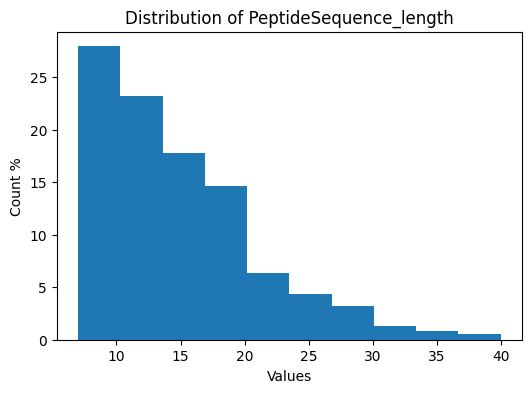

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
axes = [axes]
# fig.tight_layout()
for ax, col in zip(axes, numerical_cols):
    ax.hist(data[col], weights=100*np.ones(len(data[col])) / len(data[col]))
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Count %')

<font size="6">Identifing outliers</font>

In [6]:
text_col = 'PeptideSequence'
numerical_cols = [f"{text_col}_length"]
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    data[f'{col}_is_outlier'] = (data[col] < lower_bound) | (data[col] > upper_bound)
    
    # 5. Count outliers
    num_outliers = data[f'{col}_is_outlier'].sum()
    
    print(f"{col} Outliers detected: {num_outliers}")

PeptideSequence_length Outliers detected: 94


<font size="6">Frequent characters Visualization</font>

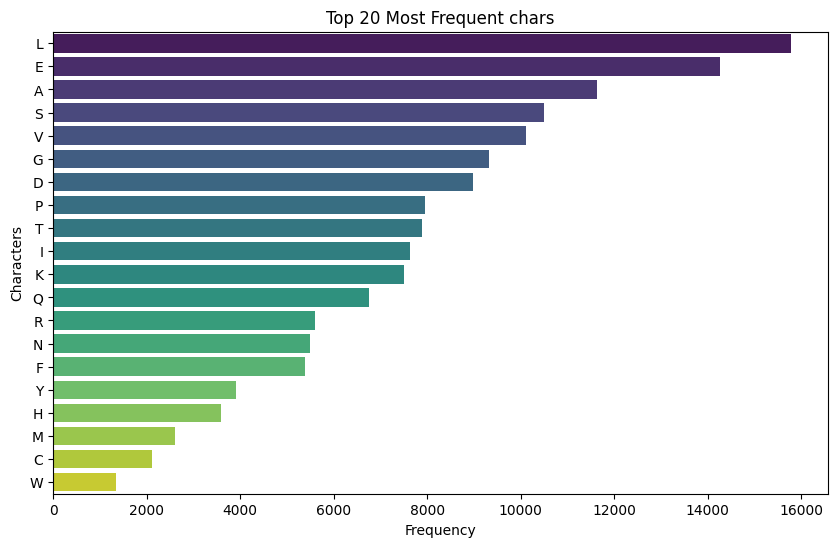

In [7]:
text_col = 'PeptideSequence'
all_chars = data[text_col].apply(lambda x: list(x))
all_chars = [char for row in all_chars for char in row]

chars_counts = Counter(all_chars)
common_chars = chars_counts.most_common(20)

chars, counts = zip(*common_chars)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(chars), palette="viridis")
plt.title("Top 20 Most Frequent chars")
plt.xlabel("Frequency")
plt.ylabel("Characters")
plt.show()

<font size="6">The label column - 'RetentionTime' </font>

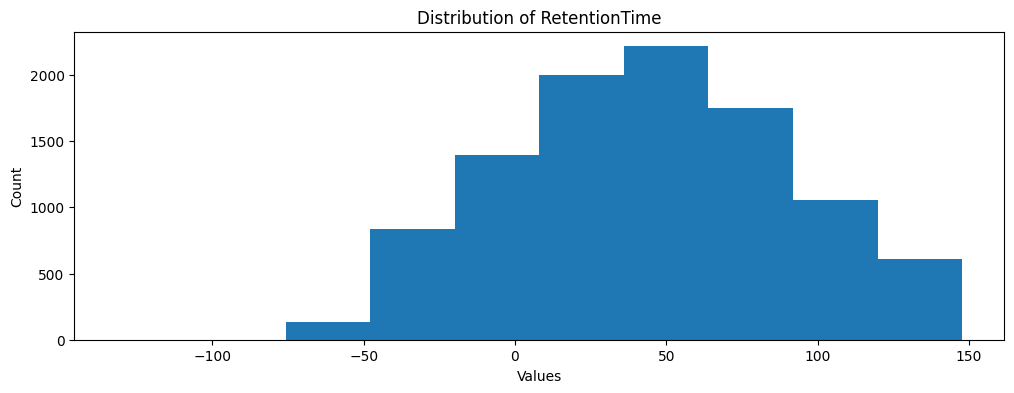

In [8]:
numerical_cols = ['RetentionTime']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes = [axes] #if only one plot
# fig.tight_layout()
for ax, col in zip(axes, numerical_cols):
    ax.hist(data[col])
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Count')

<font size="6">Identifing outliers</font>

In [13]:
numerical_cols = ['RetentionTime']
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[f'{col}_is_outlier'] = (data[col] < lower_bound) | (data[col] > upper_bound)
    
    # 5. Count outliers
    num_outliers = data[f'{col}_is_outlier'].sum()
    
    print(f"{col} Outliers detected: {num_outliers}")

RetentionTime Outliers detected: 2


<font size="6">The column - 'Modifications' </font>

In [12]:
counts = data['Modifications'].value_counts()
print(counts)

Modifications
1|Acetyl                     151
1|Oxidation                  100
2|Oxidation                   75
4|Oxidation                   54
5|Oxidation                   48
3|Oxidation                   44
10|Oxidation                  34
8|Oxidation                   33
7|Oxidation                   32
9|Oxidation                   30
6|Oxidation                   29
11|Oxidation                  25
14|Oxidation                  24
15|Oxidation                  21
12|Oxidation                  17
13|Oxidation                  16
20|Oxidation                  11
16|Oxidation                  10
18|Oxidation                  10
19|Oxidation                   9
17|Oxidation                   9
21|Oxidation                   5
24|Oxidation                   4
25|Oxidation                   4
23|Oxidation                   3
22|Oxidation                   3
29|Oxidation                   2
30|Oxidation                   2
27|Oxidation                   1
4|Oxidation|13|Oxidation     